
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance


In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [3]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [30]:
# Split data into features and target
X = ha.drop("cp", axis=1)  # Features
y = ha["cp"]              # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a ColumnTransformer for preprocessing
ct = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),  # Standardize numerical features
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "output", "restecg"])  # One-hot encode categorical features
    ]
)

In [32]:
from sklearn.model_selection import StratifiedKFold

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in stratified_kfold.split(X, y):
    # Use .iloc for pandas DataFrame to select rows by positional index
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Now you can train and evaluate your model within this loop
    print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (218, 7) Test size: (55, 7)
Train size: (218, 7) Test size: (55, 7)
Train size: (218, 7) Test size: (55, 7)
Train size: (219, 7) Test size: (54, 7)
Train size: (219, 7) Test size: (54, 7)


In [38]:
# Create the KNN pipeline
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier())  # KNN Classifier
])

# Train the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = knn_pipeline.predict(X_test)

roc_auc_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Output the mean ROC AUC score across folds
print("ROC AUC Scores for each fold:", roc_auc_scores)
print("Mean ROC AUC Score:", roc_auc_scores.mean())

# Generate the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)

# Optional: Add a classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC AUC Scores for each fold: [0.34090909 0.52272727 0.63636364 0.61363636 0.44186047]
Mean ROC AUC Score: 0.5110993657505285
Confusion Matrix:
[[17  2  6  0]
 [ 2  2  4  1]
 [ 9  2  4  1]
 [ 1  1  1  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        25
           1       0.29      0.22      0.25         9
           2       0.27      0.25      0.26        16
           3       0.33      0.25      0.29         4

    accuracy                           0.44        54
   macro avg       0.37      0.35      0.36        54
weighted avg       0.42      0.44      0.43        54



In [45]:
# Define the parameter grid for KNN
param_grid = {
    "knn__n_neighbors": range(1,100),  # Number of neighbors
    "knn__weights": ["uniform", "distance"],  # Weighting strategy
    "knn__p": [1, 2]  # 1 for Manhattan, 2 for Euclidean distance
}

# Set up GridSearchCV
grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",  # Use accuracy for evaluation
    verbose=1
)

# Fit GridSearchCV to find the best parameters
grid_search_knn.fit(X_train, y_train)

# Retrieve the best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)


Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Best Parameters: {'knn__n_neighbors': 36, 'knn__p': 1, 'knn__weights': 'distance'}
Best Cross-Validation Accuracy: 0.5702959830866808


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [46]:
# Retrieve the best parameters from the grid search
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

# Extract the best hyperparameters
best_n_neighbors = best_params["knn__n_neighbors"]
best_weights = best_params["knn__weights"]
best_p = best_params["knn__p"]

# Create a new pipeline with the best parameters
best_knn_pipeline = Pipeline([
    ("preprocessing", ct),  # Same preprocessing step
    ("knn", KNeighborsClassifier(
        n_neighbors=best_n_neighbors,
        weights=best_weights,
        p=best_p
    ))  # Apply the best parameters
])

# Fit the new model
best_knn_pipeline.fit(X_train, y_train)

# Make predictions with the tuned model
y_pred = best_knn_pipeline.predict(X_test)

# Evaluate the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned KNN Model: {accuracy:.2f}")

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'knn__n_neighbors': 36, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy of Tuned KNN Model: 0.50

Confusion Matrix:
[[15  2  8  0]
 [ 1  3  5  0]
 [ 5  2  9  0]
 [ 1  0  3  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64        25
           1       0.43      0.33      0.38         9
           2       0.36      0.56      0.44        16
           3       0.00      0.00      0.00         4

    accuracy                           0.50        54
   macro avg       0.37      0.37      0.36        54
weighted avg       0.49      0.50      0.49        54



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.44


## Decision Tree

In [35]:
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    "decision_tree__max_depth": [None, 2, 3, 4, 5],
    "decision_tree__min_samples_split": [2, 5, 10],
    "decision_tree__min_samples_leaf": [1, 2, 4],
    "decision_tree__criterion": ["gini", "entropy"]
}

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on Test Data
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 2, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 2}

Test Accuracy: 0.48148148148148145

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.00      0.00      0.00         9
           2       0.35      0.75      0.48        16
           3       0.00      0.00      0.00         4

    accuracy                           0.48        54
   macro avg       0.26      0.33      0.28        54
weighted avg       0.43      0.48      0.43        54



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
preprocessing = best_model.named_steps["preprocessing"]

# Get feature names from the ColumnTransformer
feature_names = preprocessing.get_feature_names_out()

[Text(0.5, 0.8333333333333334, 'onehot__output_0 <= 0.5\nentropy = 1.731\nsamples = 219\nvalue = [103, 35, 65, 16]\nclass = Class 0'),
 Text(0.25, 0.5, 'scale__trtbps <= 0.603\nentropy = 1.797\nsamples = 112\nvalue = [23, 28, 51, 10]\nclass = Class 2'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'entropy = 1.75\nsamples = 94\nvalue = [22, 26, 41, 5]\nclass = Class 2'),
 Text(0.375, 0.16666666666666666, 'entropy = 1.568\nsamples = 18\nvalue = [1, 2, 10, 5]\nclass = Class 2'),
 Text(0.75, 0.5, 'scale__thalach <= 0.639\nentropy = 1.188\nsamples = 107\nvalue = [80.0, 7.0, 14.0, 6.0]\nclass = Class 0'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'entropy = 1.08\nsamples = 95\nvalue = [73.0, 3.0, 14.0, 5.0]\nclass = Class 0'),
 Text(0.875, 0.16666666666666666, 'entropy = 1.281\nsamples = 12\nvalue = [7, 4, 0, 1]\nclass = Class 0')]

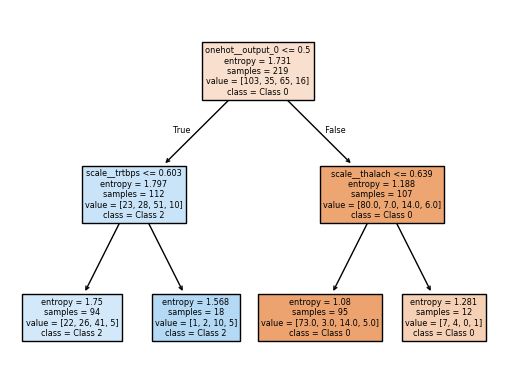

In [36]:
# Extract preprocessing step
preprocessing = best_model.named_steps["preprocessing"]

# Get feature names from the ColumnTransformer
feature_names = preprocessing.get_feature_names_out()

# Extract the decision tree classifier
decision_tree = best_model.named_steps["decision_tree"]

# Plot the decision tree
from sklearn.tree import plot_tree
plot_tree(
    decision_tree,
    feature_names=feature_names,  # Automatically extracted feature names
    class_names=["Class 0", "Class 1", "Class 2", "Class 3"],  # Replace with actual class labels
    filled=True
)

In [8]:
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [53]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Assuming `ha` is your dataset and `cp` is the column to process
# Create dummy variables for `cp` and rename columns
cp_dummies = pd.get_dummies(ha['cp'], prefix='cp_is')

# Add dummy variables to the original DataFrame
ha = pd.concat([ha, cp_dummies], axis=1)
ha




,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_0,cp_is_1,cp_is_2,cp_is_3
0,63,1,3,145,233,0,150,1,False,False,False,True
1,37,1,2,130,250,1,187,1,False,False,True,False
2,56,1,1,120,236,1,178,1,False,True,False,False
3,57,0,0,120,354,1,163,1,True,False,False,False
4,57,1,0,140,192,1,148,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0,True,False,False,False
269,57,0,0,140,241,1,123,0,True,False,False,False
270,45,1,3,110,264,1,132,0,False,False,False,True
271,68,1,0,144,193,1,141,0,True,False,False,False


In [58]:
# Results dictionary to store F1 scores
results = {}

# Iterate over each dummy variable (e.g., cp_is_0, cp_is_1, etc.)
for dummy_col in cp_dummies.columns:
    # Define the current binary target
    # y = ha['cp_is_3']  # Select only one dummy column as target

    # # Prepare features (exclude the `cp` column and all dummy columns)
    # X = ha.drop(columns=['cp', 'cp_is_0','cp_is_1','cp_is_2','cp_is_3'])

    y = ha[dummy_col]  # Dynamically select the dummy column as target

    # Prepare features (exclude the `cp` column and all dummy columns)
    X = ha.drop(columns=['cp'] + cp_dummies.columns.tolist())

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Fit Logistic Regression
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)  # y_train is now 1D (single column)

    # Predict and calculate F1 Score
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[dummy_col] = f1

    print(f"F1 Score for {dummy_col}: {f1:.2f}")

# Find the best category based on F1 Score
best_category = max(results, key=results.get)
print(f"\nThe OvR approach was best at distinguishing {best_category} with an F1 Score of {results[best_category]:.2f}")

F1 Score for cp_is_0: 0.75
F1 Score for cp_is_1: 0.00
F1 Score for cp_is_2: 0.10
F1 Score for cp_is_3: 0.00

The OvR approach was best at distinguishing cp_is_0 with an F1 Score of 0.75


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Define chest pain categories to compare
categories_to_compare = [
    (0, 1),  # Compare 0 vs 1
    (0, 2),  # Compare 0 vs 2
    (0, 3)   # Compare 0 vs 3
]

# Results dictionary to store ROC-AUC scores
roc_auc_results = {}

# Iterate over category pairs
for cat1, cat2 in categories_to_compare:
    # Filter dataset to only include the two categories
    ha_filtered = ha[ha['cp'].isin([cat1, cat2])]

    # Define features (X) and binary target (y)
    X = ha_filtered.drop(columns=['cp'])  # Features
    y = (ha_filtered['cp'] == cat2).astype(int)  # Binary target: cat2 = 1, cat1 = 0

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Fit Logistic Regression
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_proba)
    roc_auc_results[(cat1, cat2)] = roc_auc

    print(f"ROC-AUC for {cat1} vs {cat2}: {roc_auc:.2f}")

# Find the best pair based on ROC-AUC
best_pair = max(roc_auc_results, key=roc_auc_results.get)
print(f"\nThe OvO approach was best at distinguishing {best_pair} with an ROC-AUC of {roc_auc_results[best_pair]:.2f}")


ROC-AUC for 0 vs 1: 0.63
ROC-AUC for 0 vs 2: 0.89
ROC-AUC for 0 vs 3: 0.63

The OvO approach was best at distinguishing (0, 2) with an ROC-AUC of 0.89
